In [3]:
import pandas as pd
import sympy as smp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

import math

import scipy
from scipy import integrate
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.optimize import newton
import scipy.special as special
from scipy.integrate import quad
from scipy import inf

$$ \psi(x, 0 ) = \mathcal{N} e^{-\frac{(x - x_0)^2}{2 \sigma^2}} $$

Найти различия эволюции волновой функции дельта яме и без неё

$$ V(x) = - \frac{\hbar^2 \varkappa}{m} \delta(x)$$

Из уравнения Шредингера и нормировки на дельта функцию получаем следующие станционарные состояние:

$$\psi_k = \frac{1}{\sqrt{\pi (1 + \varkappa^2 / k^2)}} \left(\cos (kx) + \frac{\varkappa}{k} \sin (k|x|) \right) $$
$$\psi_k = \frac{1}{\sqrt{\pi}} \sin (kx) $$


В случае дельта ямы добавляется 1 связанное стационарное состояние

$$ \psi_1(x) = \sqrt{\varkappa} e^{-\varkappa |x|}$$

при энергии $E = - \frac{\hbar^2}{2m} \varkappa^2$

In [4]:
C = (1 / np.pi) ** (1 / 2)

def psi_0(x, x_0 = 1, N = 1, sigma = 1):
    return N * np.exp(- (x - x_0) ** 2 / (2 * sigma ** 2))

def psi_1(x, kappa = 1):
    return kappa ** 0.5 * np.exp(-kappa * np.abs(x))

def psi_odd(x, k, kappa = 1):
    return C * np.sin(k * x)

def psi_even(x, k, kappa = 1):
    if k == 0:
        return 0

    return C / ((1 + kappa ** 2 / k ** 2)) ** 0.5 * (np.cos(k * x) - kappa / k * np.sin(k * np.abs(x)))

def coef_1(x_0 = 1, kappa = 1, N = 1, sigma = 1, by_integral = True):
    a = kappa ** 0.5 * (2 * np.pi) ** 0.5 * N * sigma * np.exp(1/2 * sigma ** 2 * kappa ** 2) / 2

    term_1 = np.exp(  kappa * x_0) * special.erf((2 ** 0.5 * x_0 + 2 ** 0.5 * kappa * sigma ** 2) / (2 * sigma))
    term_2 = np.exp(- kappa * x_0) * special.erf((2 ** 0.5 * x_0 - 2 ** 0.5 * kappa * sigma ** 2) / (2 * sigma))
    term_3 = np.exp(  kappa * x_0) + np.exp(- kappa * x_0)

    return a * (- term_1 + term_2 + term_3)

def coef_odd(k, x_0 = 1, kappa = 1, N = 1, sigma = 1):
    return C * (2 * np.pi) ** 0.5 * N * sigma * np.exp(-1/2 * sigma ** 2 * k ** 2) * np.sin(k * x_0)

def coef_even(k, x_0 = 1, kappa = 1, N = 1, sigma = 1):
    if k == 0:
        return 0

    a = C / (1 + kappa ** 2 / k ** 2) ** 0.5 * (2 * np.pi) ** 0.5 * N * sigma * np.exp(- 1 / 2 * sigma ** 2 * k ** 2)

    term_1 = kappa / (2 * k) * (np.sin(k * x_0) - 1j * np.cos(k * x_0)) * special.erf((2 ** 0.5 * x_0 + 2 ** 0.5 * 1j * k * sigma ** 2) / (2 * sigma))
    term_2 = kappa / (2 * k) * (np.sin(k * x_0) + 1j * np.cos(k * x_0)) * special.erf((2 ** 0.5 * x_0 - 2 ** 0.5 * 1j * k * sigma ** 2) / (2 * sigma))
    term_3 =                    np.cos(k * x_0)
    
    return a * (term_3 - term_1 - term_2)

def expr(k, x, t, x_0 = 1, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
    return (coef_odd(k, x_0, kappa, N, sigma) * psi_odd(x, k, kappa) + coef_even(k, x_0, kappa, N, sigma) * psi_even(x, k, kappa)) * np.exp(-1j * h * k ** 2 / (2 * m) * t)

def integral(x, t, x_0 = 1, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
    def real_func(k, x, t, x_0 = 1, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
        return np.real(expr(k, x, t, x_0, kappa, m, h, N, sigma))
    def imag_func(k, x, t, x_0 = 1, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
        return np.imag(expr(k, x, t, x_0, kappa, m, h, N, sigma))
    a = 0
    b = 18
    real_integral = integrate.quad(real_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))
    imag_integral = integrate.quad(imag_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))   
    return real_integral[0] + 1j*imag_integral[0]

def expr_k(x, k, psi_0, t, x_0 = 1, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
    return psi_0 * np.exp(-1j * k * x)

def integral_k(k, t, psi_0, x_0 = 1, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
    def real_func(x, k, t, psi_0, x_0 = 1, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
        return np.real(expr_k(x, k, t, psi_0, x_0, kappa, m, h, N, sigma))
    def imag_func(x, k, t, psi_0, x_0 = 1, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
        return np.imag(expr_k(x, k, t, psi_0, x_0, kappa, m, h, N, sigma))
    a = -20
    b = 20
    real_integral = integrate.quad(real_func, a, b, args=(k, t, psi_0, x_0, kappa, m, h, N, sigma))
    imag_integral = integrate.quad(imag_func, a, b, args=(k, t, psi_0, x_0, kappa, m, h, N, sigma))   
    return real_integral[0] + 1j*imag_integral[0]

def psi(x, t, x_0 = 0, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
    return np.abs(integral(x, t, x_0, kappa, m, h, N, sigma) + coef_1(x_0, kappa, N, sigma) * psi_1(x, kappa) * np.exp(-1j * h * kappa ** 2 / (2 * m) * t))

def psi_k(k, t, psi_0, x_0 = 0, kappa = 1, m = 1, h = 1, N = 1, sigma = 1):
    return np.abs(integral_k(k, t, psi_0, x_0, kappa, m, h, N, sigma))

/tmp/ipykernel_2369/2851319072.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_integral = integrate.quad(real_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))
/tmp/ipykernel_2369/2851319072.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integ

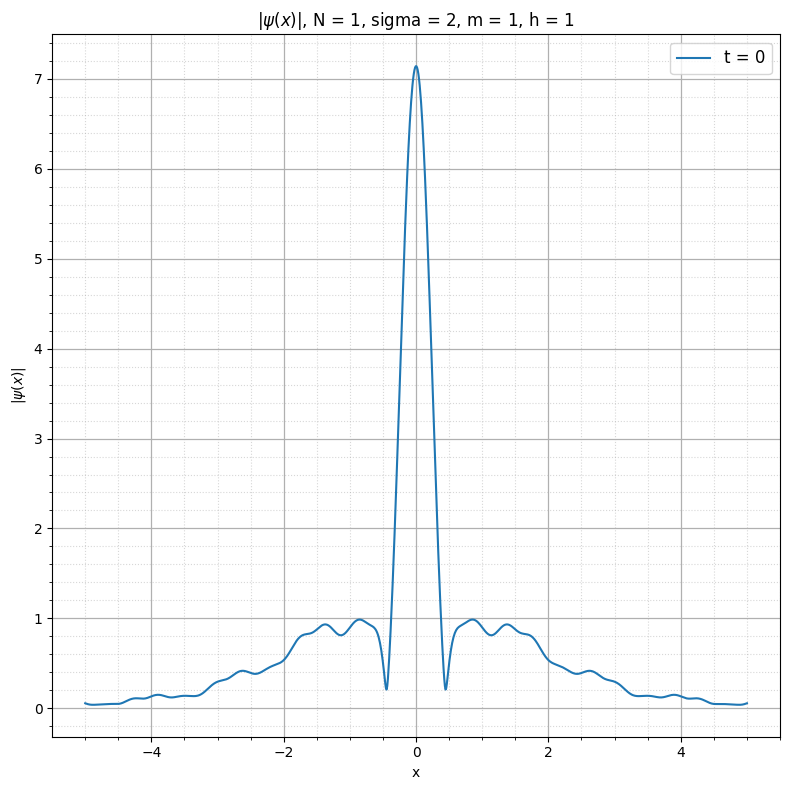

In [17]:
mpl.rcParams['font.size'] = 16                   # Управление стилем, в данном случаем - размером шрифта 
plt.figure(figsize = (8,8), facecolor = "white") # Создаем фигуру
plt.style.use('default')
# Подписываем оси и график
plt.title(r'$|\psi(x)|$, N = 1, sigma = 2, m = 1, h = 1')
plt.ylabel(r'$|\psi(x)|$')
plt.xlabel(r"x")

x = np.linspace(-5, 15, 1000)
k = np.linspace(-5, 5, 1000)

res_0 = []
res_1 = []
res_2 = []
res_3 = []

for i in x:
    res_0.append(psi(i, 10, 2.5, 1, 1, 1, 1, 2))
    # res_1.append(np.abs(psi(i, 1, 1, 0.25, 1, 1, 1, 2)))
    # res_2.append(np.abs(psi(i, 2, 1, 0.25, 1, 1, 1, 2)))
    # res_3.append(np.abs(psi(i, 3, 1, 0.25, 1, 1, 1, 2)))

res_k = []

delta = x[1] - x[0]
for j in k:
    sum_1 = 0
    for i in range(len(x)):
        sum_1 += res_0[i] * np.exp(-1j * j * x[i]) * delta
    res_k.append(sum_1)


plt.plot(k, np.abs(np.asarray(res_k)), label='t = 0')
# plt.plot(x, res_1, label='t = 1')
# plt.plot(x, res_2, label='t = 2')
# plt.plot(x, res_3, label='t = 3')

plt.grid(visible = True, which = 'major', axis = 'both', alpha = 1, linewidth = 0.9)   # Активируем сетку
plt.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.5, linestyle = ':')

plt.minorticks_on()
plt.tight_layout()
plt.legend(loc='best', fontsize = 12) # Активируем легенду графика
plt.show()

0
1
2


/tmp/ipykernel_3217/4124740658.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_integral = integrate.quad(real_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))
/tmp/ipykernel_3217/4124740658.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integ

3
4
5
6
7
8


/tmp/ipykernel_3217/4124740658.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  imag_integral = integrate.quad(imag_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))
/tmp/ipykernel_3217/4124740658.py:52: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  real_integral = integrate.quad(real_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


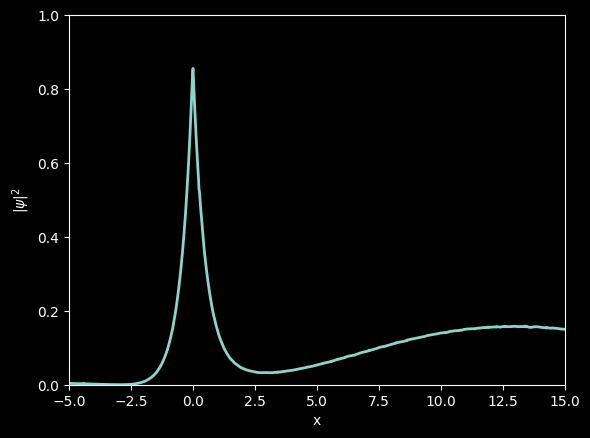

In [4]:
plt.style.use('dark_background')
 
fig = plt.figure()
ax = plt.axes(xlim=(-5, 15), ylim=(0, 1))
line, = ax.plot([], [], lw=2)
ax.set_xlabel("x")
ax.set_ylabel(r"$|\psi|^2$")
 
# Функция инициализации.
def init():
    # создение пустого графа.
    line.set_data([], [])
    return line,
 
xdata, ydata = [], []
 
# функция анимации
def animate(i):
    # x, y данные на графике
    x = np.linspace(-5, 15, 1000)
    y = []
    
    for j in x:
        y.append((np.abs(psi(j, i, 2.5, 1, 1, 1, 1, 2))) ** 2)
 
    line.set_data(x, y)
    print(i)
    return line,
  
# Вызов анимации
anim = FuncAnimation(fig, animate, init_func=init, frames=30, interval=100, blit=True)
 
# Сохраняем анимацию как gif файл
anim.save('evol_2.gif', writer='pillow')

0
1
2


/tmp/ipykernel_2369/2851319072.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_integral = integrate.quad(real_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))
/tmp/ipykernel_2369/2851319072.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integ

3
4
5
6
7
8


/tmp/ipykernel_2369/2851319072.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  imag_integral = integrate.quad(imag_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))
/tmp/ipykernel_2369/2851319072.py:52: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  real_integral = integrate.quad(real_func, a, b, args=(x, t, x_0, kappa, m, h, N, sigma))


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


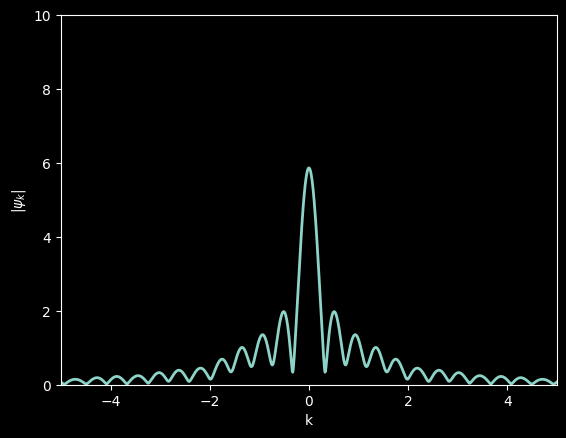

In [14]:
plt.style.use('dark_background')
 
fig = plt.figure()
ax = plt.axes(xlim=(-5, 5), ylim=(0, 10))
line, = ax.plot([], [], lw=2)
ax.set_xlabel("k")
ax.set_ylabel(r"$|\psi_k|$")
 
# Функция инициализации.
def init():
    # создение пустого графа.
    line.set_data([], [])
    return line,
 
xdata, ydata = [], []
 
# функция анимации
def animate(i):
    # x, y данные на графике
    x = np.linspace(-5, 15, 1000)
    y = []
    
    for j in x:
        y.append(psi(j, i, 2.5, 1, 1, 1, 1, 2))

    k = np.linspace(-5, 5, 1000)

    res_k = []
    delta = x[1] - x[0]
    for j in k:
        sum_1 = 0
        for m in range(len(x)):
            sum_1 += y[m] * np.exp(-1j * j * x[m]) * delta
        res_k.append(sum_1)
 
    line.set_data(k, np.abs(np.asarray(res_k)))
    print(i)
    return line,
  
# Вызов анимации
anim = FuncAnimation(fig, animate, init_func=init, frames=30, interval=100, blit=True)

# Сохраняем анимацию как gif файл
anim.save('evol_2.gif', writer='pillow')